# DIA Capstone

## 1. Data

### 1a. Load relevant libraries 

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import math

### 1b. Load the data

In [2]:
DIA = pd.read_csv('DIA (3).csv')

## 2. Data Wrangling

In [3]:
DIA.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2015,178.649994,179.229996,176.979996,177.940002,153.454803,4997200
1,1/5/2015,177.059998,177.210007,174.460007,174.839996,150.781387,6700200
2,1/6/2015,175.100006,175.539993,172.320007,173.389999,149.530914,10131400
3,1/7/2015,174.850006,175.789993,174.240005,175.589996,151.428162,5547000
4,1/8/2015,177.259995,178.960007,177.210007,178.759995,154.161942,7166700


In [4]:
DIA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1257 non-null   object 
 1   Open       1257 non-null   float64
 2   High       1257 non-null   float64
 3   Low        1257 non-null   float64
 4   Close      1257 non-null   float64
 5   Adj Close  1257 non-null   float64
 6   Volume     1257 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [5]:
DIA['Date'] = pd.to_datetime(DIA['Date'])

In [6]:
DIA = DIA.set_index('Date').asfreq('B').ffill()

In [7]:
DIA['% Change in Price'] = DIA['Adj Close'].pct_change()

In [8]:
DIA['% Change in Volume'] = DIA['Adj Close'].pct_change()

## 3. EDA

In [9]:
DIA['Adj Close'].describe()

count    1302.000000
mean      199.534848
std        40.306973
min       136.997742
25%       157.495525
50%       195.819824
75%       236.760735
max       276.615112
Name: Adj Close, dtype: float64

Text(0, 0.5, 'Price')

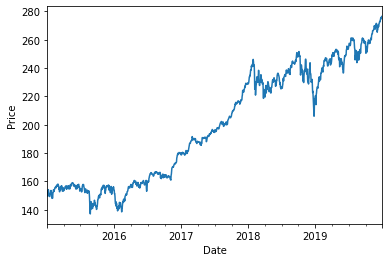

In [10]:
_ = DIA['Adj Close'].plot()
plt.ylabel('Price')

Text(0.5, 0, 'Price')

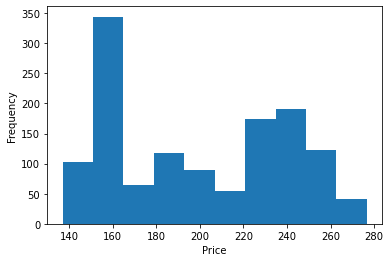

In [11]:
_ = DIA['Adj Close'].plot(kind = 'hist')
plt.xlabel('Price')

Text(0.5, 0, 'Price')

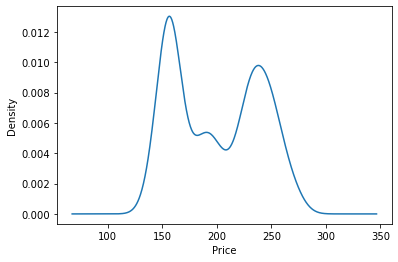

In [12]:
_ = DIA['Adj Close'].plot(kind = 'kde')
plt.xlabel('Price')

In [13]:
DIA['Volume'].describe()

count    1.302000e+03
mean     4.372181e+06
std      2.853058e+06
min      6.116000e+05
25%      2.511075e+06
50%      3.651900e+06
75%      5.376775e+06
max      3.510240e+07
Name: Volume, dtype: float64

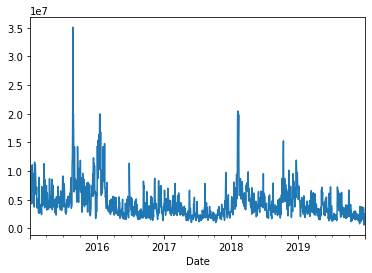

In [14]:
_ = DIA['Volume'].plot()

Text(0, 0.5, 'Change')

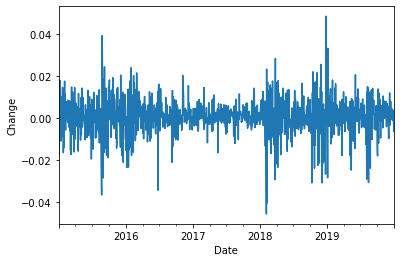

In [15]:
_ = DIA['% Change in Price'].plot()
plt.ylabel('Change')

Text(0.5, 0, 'Change')

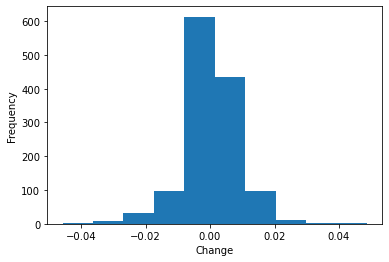

In [16]:
_ = DIA['% Change in Price'].plot(kind = 'hist')
plt.xlabel('Change')

Text(0.5, 0, 'Change')

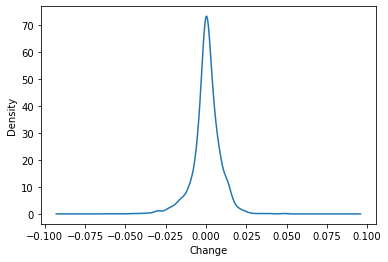

In [17]:
_ = DIA['% Change in Price'].plot(kind = 'kde')
plt.xlabel('Change')

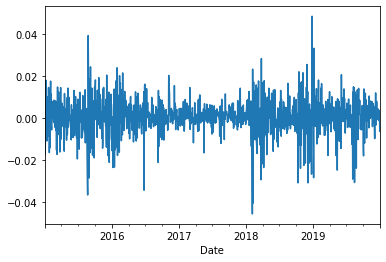

In [18]:
_ = DIA['% Change in Volume'].plot()

<AxesSubplot:ylabel='Frequency'>

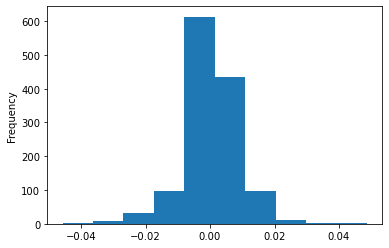

In [19]:
DIA['% Change in Volume'].plot(kind = 'hist')

## 4. Preprocessing and Modeling

### 4a. Train-Test Split

In [20]:
y = DIA['Adj Close']

In [21]:
    split=int(len(y) * 0.65) 
    # Make train and test variables, with 'train, test'
    train, test = y[0:split], y[split:len(y)]

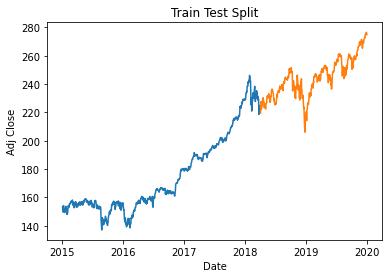

In [22]:
plt.plot(train)
plt.plot(test)
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.title('Train Test Split')
plt.show()

### 4b. Arima

### 4bi. Decomposition

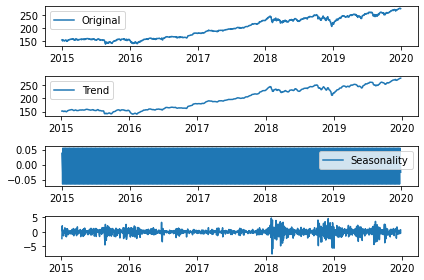

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(y)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original data, the trend, the seasonality, and the residuals 
plt.subplot(411)
plt.plot(y, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = "Seasonality")
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = "Residual")
plt.tight_layout()

### 4bii. Stationarity

In [24]:
from statsmodels.tsa.stattools import kpss
kpss(y)

C:\Users\yorik\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\yorik\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(5.3803298534460815,
 0.01,
 23,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [25]:
y_log = np.log(y)

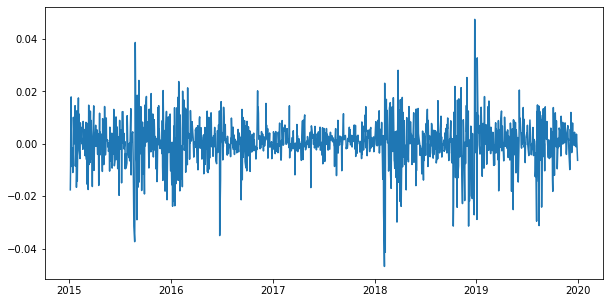

In [26]:
_ = plt.figure(figsize=(10,5))
_ = plt.plot(y_log.diff())

In [27]:
kpss(y_log.diff().dropna())

C:\Users\yorik\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.08738928379019296,
 0.1,
 23,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

### 4.biii ARIMA model

In [28]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    split=int(len(data) * 0.65) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

In [29]:
# Make a function called evaluate_models to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.6f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.6f' % (best_cfg, best_score))

In [30]:
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [31]:
import warnings
warnings.filterwarnings("ignore")
evaluate_models(y_log, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.078598
ARIMA(0, 0, 1) MSE=0.020535
ARIMA(0, 1, 0) MSE=0.000080
ARIMA(0, 1, 1) MSE=0.000080
ARIMA(0, 1, 2) MSE=0.000081
ARIMA(0, 2, 0) MSE=0.000159
ARIMA(0, 2, 1) MSE=0.000081
ARIMA(0, 2, 2) MSE=0.000081
ARIMA(1, 0, 0) MSE=0.000081
ARIMA(1, 1, 0) MSE=0.000080
ARIMA(1, 1, 1) MSE=0.000081
ARIMA(1, 1, 2) MSE=0.000081
ARIMA(1, 2, 0) MSE=0.000121
ARIMA(2, 0, 0) MSE=57123.249223
ARIMA(2, 1, 0) MSE=0.000081
ARIMA(2, 1, 1) MSE=0.000081
ARIMA(2, 1, 2) MSE=0.000082
ARIMA(2, 2, 0) MSE=0.000109
ARIMA(2, 2, 1) MSE=0.000081
ARIMA(2, 2, 2) MSE=0.000082
Best ARIMA(0, 1, 0) MSE=0.000080


### 4.bvi Best ARIMA model

In [32]:
p=0
d=1
q=0
model = ARIMA(y_log, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(12)

In [33]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Adj Close   No. Observations:                 1301
Model:                 ARIMA(0, 1, 0)   Log Likelihood                4374.443
Method:                           css   S.D. of innovations              0.008
Date:                Sat, 04 Dec 2021   AIC                          -8744.885
Time:                        15:54:33   BIC                          -8734.543
Sample:                    01-05-2015   HQIC                         -8741.005
                         - 12-30-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.927      0.054   -7.58e-06       0.001
==============================================================================
"""

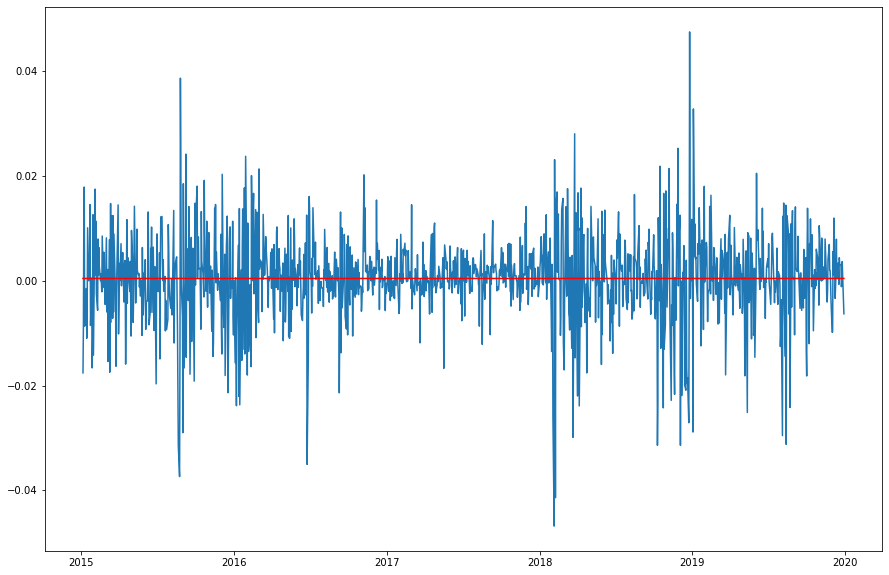

In [34]:
# Call figure() and plot() on the plt
plt.figure(figsize=(15,10))
plt.plot(y_log.diff())
plt.plot(model_fit.predict(), color = 'red')

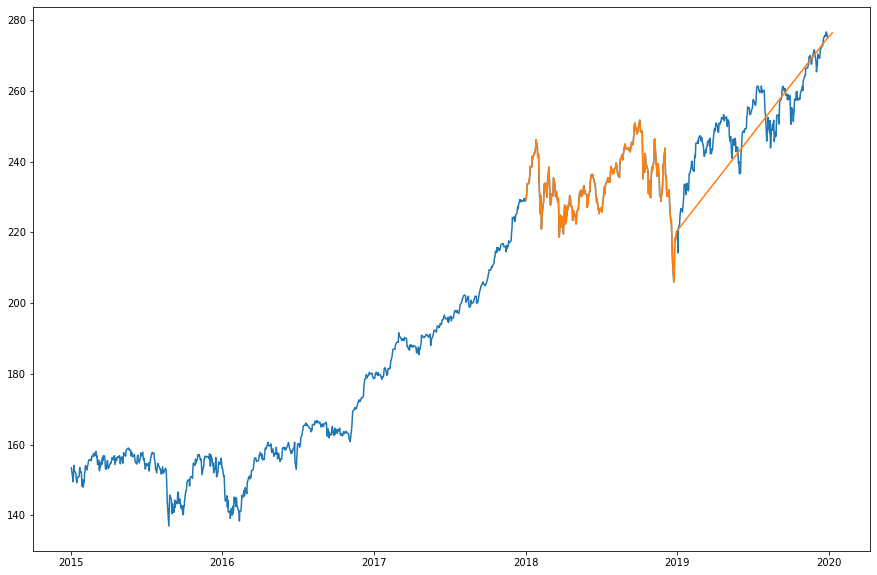

In [35]:
forecast_period = 12
date_range = pd.date_range(y_log.index[-1], periods = forecast_period, \
                           freq='D').strftime("%Y-%m-%d").tolist()

future_dates = pd.DataFrame(date_range, columns = ['Date'])
future_dates['Date'] = pd.to_datetime(future_dates['Date'])
future_dates.set_index('Date', inplace = True)
future_dates['Prediction'] = forecast[0]


plt.figure(figsize=(15,10))
plt.plot(y)
plt.plot(y['2018'].append(np.exp(future_dates['Prediction'])))
plt.show()

## 4c. LSTM

In [36]:
y.head()

Date
2015-01-02    153.454803
2015-01-05    150.781387
2015-01-06    149.530914
2015-01-07    151.428162
2015-01-08    154.161942
Freq: B, Name: Adj Close, dtype: float64

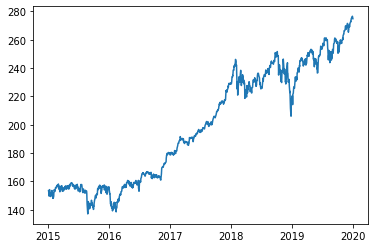

In [37]:
plt.plot(y)
plt.show()

### 4ci. Scaling

In [38]:
# Scaling the data since LSTM is sensitive to the scale of the data
scaler=MinMaxScaler(feature_range=(0,1))
y=scaler.fit_transform(np.array(y).reshape(-1,1))

In [39]:
y

array([[0.11787259],
       [0.09872443],
       [0.089768  ],
       ...,
       [0.99813202],
       [1.        ],
       [0.98754509]])

### 4. cii LSTM model

In [40]:
# train , test split
training_size=int(len(y)*0.65)
test_size=len(y)-training_size
train_data,test_data=y[0:training_size,:],y[training_size:len(y),:1]

In [41]:
training_size,test_size

(846, 456)

In [42]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [43]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [44]:
X_train.shape, y_train.shape

((745, 100), (745,))

In [45]:
X_test.shape, y_test.shape

((355, 100), (355,))

In [46]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [47]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [48]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 8s 291ms/step - loss: 0.0290 - val_loss: 0.0492
Epoch 2/100
12/12 [==============================] - 2s 162ms/step - loss: 0.0051 - val_loss: 0.0032
Epoch 3/100
12/12 [==============================] - 2s 152ms/step - loss: 0.0015 - val_loss: 0.0041
Epoch 4/100
12/12 [==============================] - 2s 143ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 5/100
12/12 [==============================] - 2s 148ms/step - loss: 7.5767e-04 - val_loss: 0.0022
Epoch 6/100
12/12 [==============================] - 2s 143ms/step - loss: 7.0803e-04 - val_loss: 0.0020
Epoch 7/100
12/12 [==============================] - 2s 142ms/step - loss: 6.7690e-04 - val_loss: 0.0021
Epoch 8/100
12/12 [==============================] - 2s 142ms/step - loss: 6.7872e-04 - val_loss: 0.0027
Epoch 9/100
12/12 [==============================] - 2s 142ms/step - loss: 7.3321e-04 - val_loss: 0.0031
Epoch 10/100
12/12 [==============================] - 2s 153ms/step - l

12/12 [==============================] - 2s 170ms/step - loss: 3.2463e-04 - val_loss: 0.0014
Epoch 79/100
12/12 [==============================] - 2s 164ms/step - loss: 3.4365e-04 - val_loss: 0.0011
Epoch 80/100
12/12 [==============================] - 2s 169ms/step - loss: 3.0462e-04 - val_loss: 0.0015
Epoch 81/100
12/12 [==============================] - 2s 156ms/step - loss: 2.7767e-04 - val_loss: 0.0014
Epoch 82/100
12/12 [==============================] - 2s 172ms/step - loss: 2.9058e-04 - val_loss: 0.0013
Epoch 83/100
12/12 [==============================] - 2s 178ms/step - loss: 2.7791e-04 - val_loss: 0.0011
Epoch 84/100
12/12 [==============================] - 2s 171ms/step - loss: 3.0338e-04 - val_loss: 0.0011
Epoch 85/100
12/12 [==============================] - 2s 161ms/step - loss: 3.4016e-04 - val_loss: 0.0018
Epoch 86/100
12/12 [==============================] - 2s 170ms/step - loss: 3.2969e-04 - val_loss: 0.0052
Epoch 87/100
12/12 [==============================] - 2s 16

In [49]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [50]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [51]:
mean_squared_error(y_train, train_predict)

31881.088139516814

In [52]:
mean_squared_error(y_test,test_predict)

58296.422525236776

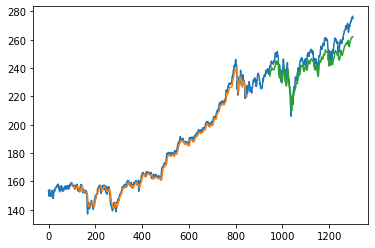

In [53]:
# Plotting 
look_back=100
trainPredictPlot = np.empty_like(y)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(y)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(y)-1, :] = test_predict
# plot
plt.plot(scaler.inverse_transform(y))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [54]:
len(test_data)

456

In [55]:
x_input=test_data[356:].reshape(1,-1)
x_input.shape

(1, 100)

In [56]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [57]:
_ = temp_input

In [58]:
# prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    



[0.8965544]
101
1 day input [0.76523263 0.77399616 0.79592248 0.81280976 0.80148282 0.81754682
 0.82118498 0.77814263 0.79743275 0.78850824 0.80628864 0.83038338
 0.83196229 0.83196229 0.81335905 0.83058917 0.85633255 0.86072601
 0.8640211  0.86807139 0.88386096 0.88818535 0.89010776 0.88029111
 0.88296806 0.8857825  0.8820074  0.87152737 0.87228387 0.86271902
 0.87379754 0.86898135 0.86285651 0.87104539 0.84572246 0.81283009
 0.82170728 0.84682322 0.84049238 0.81874868 0.83147802 0.84235009
 0.864027   0.8619623  0.87820192 0.87723864 0.8793027  0.86162722
 0.86555226 0.86286635 0.8657586  0.86396821 0.87512345 0.88345485
 0.88386796 0.88985902 0.88118292 0.90087481 0.90920708 0.91099725
 0.91092796 0.92642135 0.92655862 0.92717852 0.9280736  0.93330641
 0.9345462  0.94988811 0.9521644  0.94567957 0.93788522 0.93457395
 0.94243737 0.95582038 0.95968334 0.96347811 0.96347811 0.95685535
 0.93788522 0.91932886 0.92995164 0.93209045 0.95513075 0.94864614
 0.94657706 0.94836986 0.96375396 

9 day output [[0.66834724]]
10 day input [0.78850824 0.80628864 0.83038338 0.83196229 0.83196229 0.81335905
 0.83058917 0.85633255 0.86072601 0.8640211  0.86807139 0.88386096
 0.88818535 0.89010776 0.88029111 0.88296806 0.8857825  0.8820074
 0.87152737 0.87228387 0.86271902 0.87379754 0.86898135 0.86285651
 0.87104539 0.84572246 0.81283009 0.82170728 0.84682322 0.84049238
 0.81874868 0.83147802 0.84235009 0.864027   0.8619623  0.87820192
 0.87723864 0.8793027  0.86162722 0.86555226 0.86286635 0.8657586
 0.86396821 0.87512345 0.88345485 0.88386796 0.88985902 0.88118292
 0.90087481 0.90920708 0.91099725 0.91092796 0.92642135 0.92655862
 0.92717852 0.9280736  0.93330641 0.9345462  0.94988811 0.9521644
 0.94567957 0.93788522 0.93457395 0.94243737 0.95582038 0.95968334
 0.96347811 0.96347811 0.95685535 0.93788522 0.91932886 0.92995164
 0.93209045 0.95513075 0.94864614 0.94657706 0.94836986 0.96375396
 0.96485757 0.97148033 0.97375574 0.97244492 0.98106856 0.98706071
 0.99308041 0.99086663 0

19 day output [[0.6644164]]
20 day input [0.86807139 0.88386096 0.88818535 0.89010776 0.88029111 0.88296806
 0.8857825  0.8820074  0.87152737 0.87228387 0.86271902 0.87379754
 0.86898135 0.86285651 0.87104539 0.84572246 0.81283009 0.82170728
 0.84682322 0.84049238 0.81874868 0.83147802 0.84235009 0.864027
 0.8619623  0.87820192 0.87723864 0.8793027  0.86162722 0.86555226
 0.86286635 0.8657586  0.86396821 0.87512345 0.88345485 0.88386796
 0.88985902 0.88118292 0.90087481 0.90920708 0.91099725 0.91092796
 0.92642135 0.92655862 0.92717852 0.9280736  0.93330641 0.9345462
 0.94988811 0.9521644  0.94567957 0.93788522 0.93457395 0.94243737
 0.95582038 0.95968334 0.96347811 0.96347811 0.95685535 0.93788522
 0.91932886 0.92995164 0.93209045 0.95513075 0.94864614 0.94657706
 0.94836986 0.96375396 0.96485757 0.97148033 0.97375574 0.97244492
 0.98106856 0.98706071 0.99308041 0.99086663 0.99086663 0.99813202
 1.         0.98754509 0.89655441 0.87384391 0.83983845 0.8031674
 0.76862317 0.73841524 0.

28 day output [[0.61927885]]
29 day input [0.87228387 0.86271902 0.87379754 0.86898135 0.86285651 0.87104539
 0.84572246 0.81283009 0.82170728 0.84682322 0.84049238 0.81874868
 0.83147802 0.84235009 0.864027   0.8619623  0.87820192 0.87723864
 0.8793027  0.86162722 0.86555226 0.86286635 0.8657586  0.86396821
 0.87512345 0.88345485 0.88386796 0.88985902 0.88118292 0.90087481
 0.90920708 0.91099725 0.91092796 0.92642135 0.92655862 0.92717852
 0.9280736  0.93330641 0.9345462  0.94988811 0.9521644  0.94567957
 0.93788522 0.93457395 0.94243737 0.95582038 0.95968334 0.96347811
 0.96347811 0.95685535 0.93788522 0.91932886 0.92995164 0.93209045
 0.95513075 0.94864614 0.94657706 0.94836986 0.96375396 0.96485757
 0.97148033 0.97375574 0.97244492 0.98106856 0.98706071 0.99308041
 0.99086663 0.99086663 0.99813202 1.         0.98754509 0.89655441
 0.87384391 0.83983845 0.8031674  0.76862317 0.73841524 0.71337253
 0.6935935  0.67876571 0.66834724 0.66168016 0.6580646  0.65680325
 0.65722579 0.658703

In [59]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [60]:
len(y)

1302

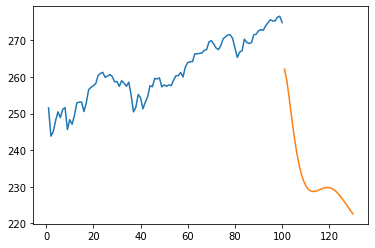

In [61]:
plt.plot(day_new,scaler.inverse_transform(y[1202:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

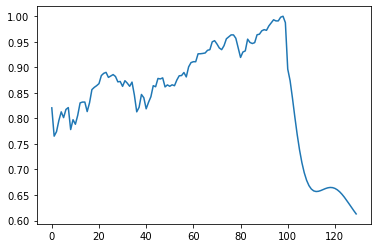

In [62]:
z=y.tolist()
z.extend(lst_output)
plt.plot(z[1202:])

In [63]:
z=scaler.inverse_transform(z).tolist()

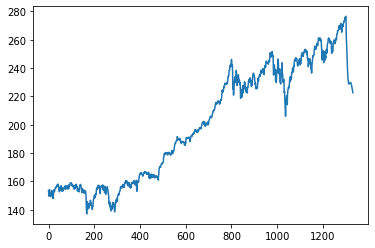

In [64]:
plt.plot(z)